### Notebook to get faculty bios and visualize keywords for University of Toronto faculty members

### Setup

In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
import openai
from wordcloud import WordCloud
import matplotlib.pyplot as plt

json_outpath = 'data/u_toronto_faculty_bios.json'
open_ai_inpath = 'd:/ai-projects/secrets/SECRETS-OPENAI.txt'

# set OpenAI api key using secrets text file
with open(open_ai_inpath, 'r') as in_file:
    openai.api_key = in_file.readlines()[0]

# # set OpenAI api key using environment variable
# import os
# openai.api_key = os.environ['OPENAI_API_KEY']


### Get dataframe with all University of Toronto Faculty of Law professors

In [3]:
# Define the base url for the faculty website
base_url = "https://www.law.utoronto.ca"

# Get the html content of the faculty page
response = requests.get(base_url+ '/faculty-staff/full-time-faculty')
soup = BeautifulSoup(response.content, "html.parser")

# Find all tables in soup
tables = soup.find_all("table")

# Iterate through all tables, getting 'name', 'phone' and 'email' for each faculty member
results = []
for table in tables:
    result = {}
    rows = table.find_all("tr")
    for row in rows:
        cols = row.find_all("td")
        if len(cols) > 0:
            name = cols[0].text.strip()
            phone = cols[1].text.strip()
            email = cols[2].text.strip()
            href = cols[0].find("a").get("href")
            result = {'name': name, 'phone': phone, 'email': email, 'href': base_url + href}
            results.append(result)

# convert result to df
df = pd.DataFrame(results)

In [4]:
# get faculty bios from each faculty member's page

def get_bio(row):
    bio = []
    response = requests.get(row['href'])
    soup = BeautifulSoup(response.content, "html.parser")

    texts = soup.find_all("div", class_="field")
    for text in texts:
        bio.append(text.text.strip())
    
    bio = '\n'.join(bio)
    time.sleep(1)
    return bio

df['bio'] = df.apply(get_bio, axis=1)


In [5]:
# Summarize faculty bios into research expertise keywords

# function to send prompt to GPT-3 and return completion
def get_completion(prompt, model_to_use):
    for attempt in range (5):
        try:
            model_output = openai.Completion.create(
            model=model_to_use,
            prompt=prompt,
            temperature= 0,
            max_tokens = 100,
            stop='\n')
            return model_output
        except:
            time.sleep(5)

# Send bio to GPT-3 and get keywords
model = 'text-davinci-003'
prompt_header = 'CONTEXT: The following text is a bio of an U Toronto Faculty of Law faculty member. \n'\
'TASK: Based on the bio provide a list of up to 5 keywords that best describe the faculty member\'s '\
'main areas of research, separated by semi-colons. List the keywords in order of importance, with the most '\
'important keyword first. \n BIO: '
suffix_header = ' \nKEYWORDS:'

# iterate through the df and get the completions
for index, row in df.iterrows():
    bio = row['bio']
    bio = bio.split('\nEducation')[0]
    bio = bio.split('\nSelected Publications')[0]
    bio = bio.split('\nSelected publications')[0]
    bio = bio.split('\nSee also Professor')[0]

    bio = bio.replace('\n', ' ').strip()
    prompt = prompt_header + bio + suffix_header
    completion = get_completion(prompt, model).choices[0].text
    df.at[index, 'keywords'] = completion
    time.sleep(2.5) # slow down to avoid openai errors

# Save to json for future use
df.to_json(json_outpath, orient='records', indent = 2)

df

,name,phone,email,href,bio,keywords
0,"Aidid, Abdi",416-978-4150,a.aidid@utoronto.ca,https://www.law.utoronto.ca/faculty-staff/full...,\nAssistant Professor\nJackman Law BuildingRoo...,Civil Procedure; Torts; Law & Technology; Mac...
1,"Alarie, Benjamin",416-946-8205,ben.alarie@utoronto.ca,https://www.law.utoronto.ca/faculty-staff/full...,\nProfessor & Osler Chair in Business Law\nJac...,Tax Law; Judicial Decision-Making; Machine Le...
2,"Anand, Anita",416-946-4002,anita.anand@utoronto.ca,https://www.law.utoronto.ca/faculty-staff/full...,\nJ.R. Kimber Chair in Investor Protection and...,Corporate Governance; Capital Markets Regulat...
3,"Austin, Lisa",416-946-7447,lisa.austin@utoronto.ca,https://www.law.utoronto.ca/faculty-staff/full...,"\nProfessor, Chair in Law and Technology\nJack...",Privacy Law; Property Law; Legal Theory; Rule...
4,"Bédard-Rubin, Jean-Christophe",,jc.bedardrubin@utoronto.ca,https://www.law.utoronto.ca/faculty-staff/full...,\nAssistant Professor\n78 Queen's Park\nAssist...,Canadian Constitutional Law; Constitutional C...
...,...,...,...,...,...,...
57,"Valcke, Catherine",416-946-8240,c.valcke@utoronto.ca,https://www.law.utoronto.ca/faculty-staff/full...,\nProfessor\nJackman Law BuildingRoom J42278 Q...,Comparative Law; Contract Law; Civil Law of O...
58,"Valverde, Mariana",,m.valverde@utoronto.ca,https://www.law.utoronto.ca/faculty-staff/full...,\nProfessor of Criminology\nComplete profile p...,Criminal Law; Sexuality and the Law; Urban La...
59,"Waddams, Stephen",416-978-4205,s.waddams@utoronto.ca,https://www.law.utoronto.ca/faculty-staff/full...,\nProfessor\nJackman Law Building78 Queen's Pa...,Contract Law; Law Reform; Equity; Fairness; E...
60,"Weinrib, Arnold",416-978-1621,arnold.weinrib@utoronto.ca,https://www.law.utoronto.ca/faculty-staff/full...,\nProfessor (Retired)\nJackman Law Building78 ...,Property; Community Planning; Taxation; Land ...


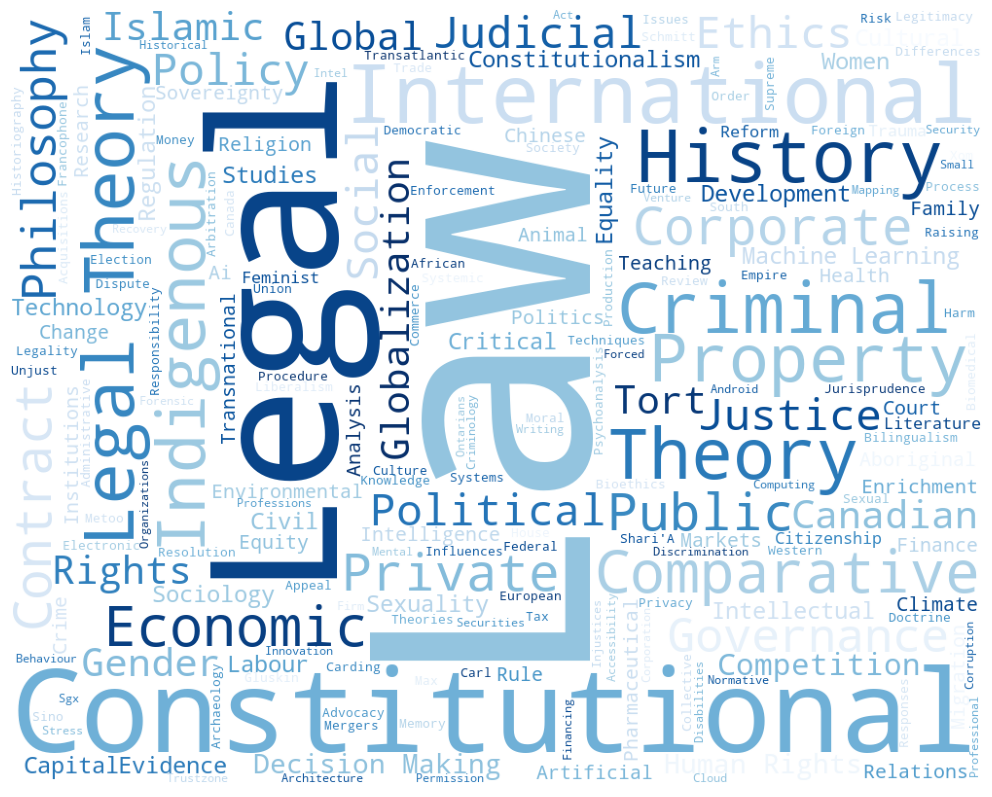

In [69]:
# Create word cloud of keywords

# create stopwords list
stopwords = [
    'Prize',
    'University',
    'Law School',
    'School of Law',
    'Osgoode',
    'Royal Society',
    'Research Council',
    'Centre'
]

# create list of keywords
keywords = []
for index, row in df.iterrows():
    phrases = row['keywords'].split(';')
    for phrase in phrases:
        phrase = phrase.replace('.', '')
        phrase = phrase.replace('/', ' and ')
        phrase = phrase.title()
        if not any(stopword in phrase for stopword in stopwords):
            keywords.append(phrase.strip())

text = '; '.join(keywords)

# Create a WordCloud object and generate the word cloud
colour_map = plt.cm.get_cmap('Blues_r', 500)
wordcloud = WordCloud(width = 1000, height = 800,
                background_color = 'white',
                min_font_size = 10,
                colormap=colour_map).generate(text)

# Display the word cloud
plt.figure(figsize = (100,10), facecolor = 'white')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 8 )
plt.show()